In [89]:
from sandbox_assets import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error, phase_damping_error,amplitude_damping_error )

Set seed:

In [90]:
seed = 1

The observable:

In [91]:
obs = QuantumCircuit(5)
obs.x(range(5))
#obs.draw(style = "default")

## Native: $\text{CX, RZ, ID, SX, X}$

Transpiling the `cswap()` gate into the above basis gates:

In [92]:
cswap_qc = QuantumCircuit(3, name = 'cswap_t')
cswap_qc.cswap(0,1,2)

cswap_t = transpile(cswap_qc, basis_gates = ['cx', 'rz', 'id', 'sx', 'x'], optimization_level = 3, seed_transpiler = seed)

#cswap_t.draw() # uncomment to draw

/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Redifining the `h()` gate into the above basis gates:

In [93]:
h_t_qc = QuantumCircuit(1, name = 'h_t')
h_t_qc.rz(np.pi/2, 0)
h_t_qc.sx(0)
h_t_qc.rz(np.pi/2, 0)

h_t = h_t_qc.to_instruction()

Redifining the `GHZ()`, `derangement()` and `circ_assembler()` functions to use the `cswap_t()` gates:

In [94]:
def GHZ_t(qc):

    registers = qc.qregs[:0:-1]
    numQubits = registers[0].size

    for reg in registers:
        qc.append(h_t, [reg[0]])

        for qubit in range(numQubits-1):
            qc.cnot(reg[qubit], reg[qubit+1])

GHZ = GHZ_t

In [95]:
def derangement_t(qc):
    
    ancilla_qubit = qc.ancillas[0]
    registers = qc.qregs[1:]
    numQubits = registers[0].size

    for i in reversed(range(1, len(registers))):
        for j in reversed(range(numQubits)):
            qc.append(cswap_t,(ancilla_qubit, registers[i][j], registers[i-1][j]))

derangement = derangement_t

In [96]:
def circ_assembler_t(numReg, numQ, numAnc, sigma, basis_gates, seed = 1, der_op = True):

    qc = iniQC(numReg, numQ, numAnc)
    GHZ(qc)
    qc.barrier()
    qc.append(h_t, [0])
    if der_op == True:
        derangement(qc)
        qc.barrier()
    if sigma != False: 
        qc = observable(sigma = sigma, qc = qc, basis_gates = basis_gates, seed = seed)
    qc.append(h_t, [0])

    return(qc)

circ_assembler = circ_assembler_t

### Exploring 1 and 2 qubit errors:

- depolarizing error:

In [112]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots

mit = [] # empty list for mitigated expectation values
unmit = [] # empty list for unmitigated expectation values

err_range = np.linspace(0,0.2,50)

for error in tqdm(err_range):
    
    err_1q = depolarizing_error(0.2*error, 1)
    err_2q = depolarizing_error(error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit.append(mit_exp)
    unmit.append(unmit_exp)


  0%|          | 0/50 [00:00<?, ?it/s]/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
100%|██████████| 50/50 [02:10<00:00,  2.60s/it]


[Text(0.5, 1.0, 'Fig. 1: Copies = 2, Shots = None, (5 qubit(s)/register)'),
 Text(0.5, 0, 'Error probability'),
 Text(0, 0.5, 'Expectation value')]

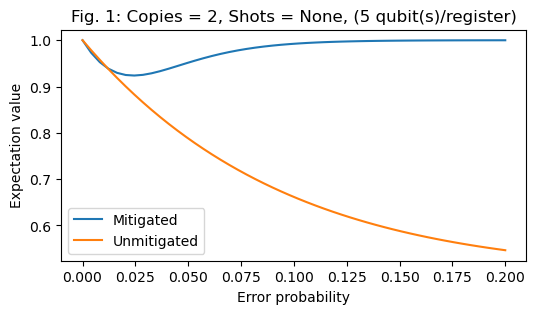

In [113]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(err_range, mit, label = 'Mitigated')
ax.plot(err_range, unmit, label = 'Unmitigated')
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='Fig. 1: Copies = {}, Shots = {}, ({} qubit(s)/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value'
)

Interesting behaviour for the mitigated case, lets explore!

First we look at the 4 expectation values for the circuits: 
- the mitigated circuit with observable
- the mitigated circuit without the observable
- the unmitigated circuit with the observable
- the unmitigated circuit without the observable

In [151]:
mit_full_circ = circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs,
                                basis_gates = basis_gates, seed = 1, der_op = True).decompose(['cswap_t', 'h_t'])

mit_no_obs_circ = circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = False,
                                basis_gates = basis_gates, seed = 1, der_op = True).decompose(['cswap_t', 'h_t'])

unmit_full_circ = circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs,
                                basis_gates = basis_gates, seed = 1, der_op = False).decompose(['cswap_t', 'h_t'])

unmit_no_obs_circ = circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = False,
                                basis_gates = basis_gates, seed = 1, der_op = False).decompose(['cswap_t', 'h_t'])

/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [115]:
mit_full = []
mit_no_obs = []
unmit_full = []
unmit_no_obs = []

err_range = np.linspace(0,0.2,50)

for i in tqdm(err_range):
    error = i

    err_1q = depolarizing_error(0.2*error, 1)
    err_2q = depolarizing_error(error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    prob_mit_no_obs = prob0(qc = mit_no_obs_circ, nb_shots = None, noise_model = noise_m)
    mit_no_obs.append(prob_mit_no_obs)

    prob_mit_full = prob0(qc = mit_full_circ, nb_shots = None, noise_model = noise_m)
    mit_full.append(prob_mit_full)

    prob_unmit_no_obs= prob0(qc = unmit_no_obs_circ, nb_shots = None, noise_model = noise_m)
    unmit_no_obs.append(prob_unmit_no_obs)

    prob_unmit_full= prob0(qc = unmit_full_circ, nb_shots = None, noise_model = noise_m)
    unmit_full.append(prob_unmit_full)


100%|██████████| 50/50 [02:09<00:00,  2.60s/it]


In [1]:

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (10, 3))
#ax.plot(np.linspace(0,0.5,50), probs_id, label = 'mitigated ID')
ax1.plot(err_range, mit_full, label = 'with observable')
ax1.plot(err_range, mit_no_obs, label = 'no observable')
ax1.set(title = 'Fig. 2: Mitigated')
ax1.legend()

ax2.plot(err_range, unmit_full, label = 'with observable')
ax2.plot(err_range, unmit_no_obs, label = 'no observable')
ax2.set(title = 'Fig. 3: Unmitigated')
ax2.legend()

plt.show()

NameError: name 'plt' is not defined

Next we look at how we calculate the final probability $\text{prob}_0$ in the `exp_value` function that is passed to the `circ_tester` function:

As we are assuming no knowladge of the dominant eigenvector's eigenvalue we are using $\text{Method A}$ from the [paper](https://arxiv.org/abs/2011.05942):

$$
\text{Method A:} \qquad \frac{2\text{prob}_0 - 1}{2\text{prob'}_0 - 1} = \textcolor{orange}{\frac{\text{Tr}[\rho^n \sigma]}{\text{Tr}[\rho^n ]}} =  \langle \psi |\sigma| \psi \rangle + \varepsilon_A
$$

We can see that in order to get the expectation value of the ancilla qubit, we divide $\text{Tr}[\rho^n \sigma]$ (on the graph: 'with observable') with $\text{Tr}[\rho^n ]$ (on the graph: 'no observable'). 

From this we can explain the behaviour of the mitigated (and also the unmitigated) circuit in *Fig. 1*:
- Due to the noise from the `derangement` operator even without the observable the expectation value will tend to $0.5$ (i.e. totally random outcomes) as we increase the noise.
- After a high enough noise (just below $0.025$) the two circuits "catch up" both giving an expectation value of $0.5$. 
- This results in a "final" expectation value of $1$ for $\text{Method A}$.

>Note:
>It is simply a coincidence that the known and 'final' noisy expectation value is one. The ESD techique does not start to magicly work better after a certain error treshold. 

- Looking at the unmitigated case, the circuit with the observable acts in a similiar fashion as in the mitigated case. Since the derangement operator is absent for the unmitigated case, less noise is introduced leading to a gentler gradient. 

- The unmitigated circuit without an observable simply consists of two hadamard gates 

In [153]:
unmit_no_obs = []

err_range = np.linspace(0,0.9,50)

for i in tqdm(err_range):
    error = i

    err_1q = depolarizing_error(error, 1)
    err_2q = depolarizing_error(error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])


    prob_unmit_no_obs= prob0(qc = test, nb_shots = None, noise_model = noise_m)
    unmit_no_obs.append(prob_unmit_no_obs)

100%|██████████| 50/50 [00:10<00:00,  4.71it/s]


[Text(0.5, 1.0, 'Fig. 1: Copies = 2, Shots = None, (5 qubit(s)/register)'),
 Text(0.5, 0, 'Error probability'),
 Text(0, 0.5, 'Expectation value')]

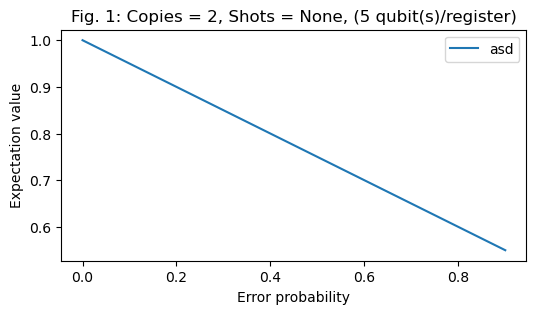

In [154]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(err_range, unmit_no_obs, label = 'asd')
#
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='Fig. 1: Copies = {}, Shots = {}, ({} qubit(s)/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value'
)

In [82]:
obs_y = QuantumCircuit(5)
obs_y.y(range(5))
obs_y.x(2)
#obs.draw(style = "default")

In [83]:
mit_full_circ = circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs_y,
                                basis_gates = basis_gates, seed = 1, der_op = True).decompose(['cswap_t', 'h_t'])

unmit_full_circ = circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs_y,
                                basis_gates = basis_gates, seed = 1, der_op = False).decompose(['cswap_t', 'h_t'])

Unexpected exception formatting exception. Falling back to standard exception


/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
Traceback (most recent call last):
  File "/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/pz/m3pnwsg120qgr6s6yyl869q80000gp/T/ipykernel_16088/3471771825.py", line 1, in <module>
    mit_full_circ = circ_assembler(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs_y,
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/pz/m3pnwsg120qgr6s6yyl869q80000gp/T/ipykernel_160

100%|██████████| 50/50 [02:06<00:00,  2.54s/it]


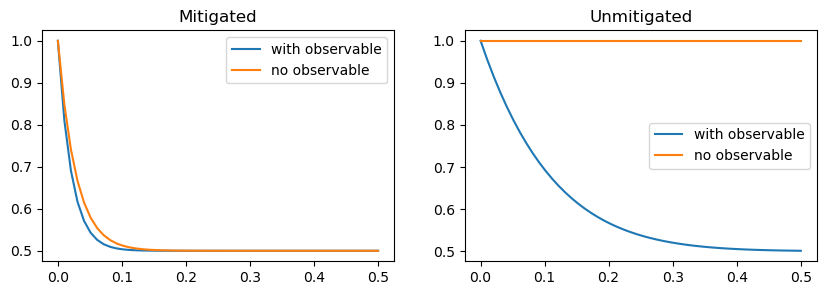

In [84]:
mit_full = []
mit_no_obs = []
unmit_full = []
unmit_no_obs = []

for i in tqdm(np.linspace(0,0.5,50)):
    error = i
    err_2q = depolarizing_error(error, 2) # 2 qubit error for cx gates in the GHZ state

    noise_simple = NoiseModel() # create noise model
    noise_simple.add_all_qubit_quantum_error(err_2q, ['cx'])

    prob_mit_no_obs = prob0(qc = mit_no_obs_circ, nb_shots = None, noise_model = noise_simple)
    mit_no_obs.append(prob_mit_no_obs)

    prob_mit_full = prob0(qc = mit_full_circ, nb_shots = None, noise_model = noise_simple)
    mit_full.append(prob_mit_full)

    prob_unmit_no_obs= prob0(qc = unmit_no_obs_circ, nb_shots = None, noise_model = noise_simple)
    unmit_no_obs.append(prob_unmit_no_obs)

    prob_unmit_full= prob0(qc = unmit_full_circ, nb_shots = None, noise_model = noise_simple)
    unmit_full.append(prob_unmit_full)


fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (10, 3))
#ax.plot(np.linspace(0,0.5,50), probs_id, label = 'mitigated ID')
ax1.plot(np.linspace(0,0.5,50), mit_full, label = 'with observable')
ax1.plot(np.linspace(0,0.5,50), mit_no_obs, label = 'no observable')
ax1.set(title = 'Mitigated')
ax1.legend()

ax2.plot(np.linspace(0,0.5,50), unmit_full, label = 'with observable')
ax2.plot(np.linspace(0,0.5,50), unmit_no_obs, label = 'no observable')
ax2.set(title = 'Unmitigated')
ax2.legend()

100%|██████████| 50/50 [00:37<00:00,  1.33it/s]


[Text(0.5, 1.0, '2 copies, 1000 shots (5 qubit/register)'),
 Text(0.5, 0, 'Error probability'),
 Text(0, 0.5, 'Expectation value')]

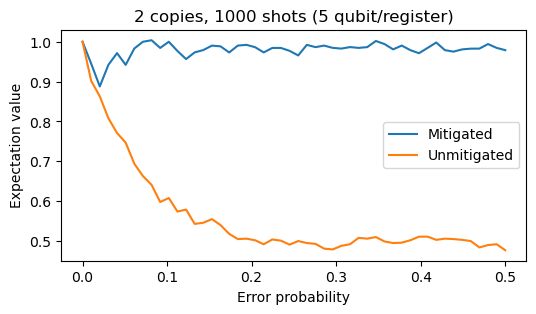

In [51]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 1000 # this time with shots!

mit = [] # empty list for mitigated expectation values
unmit = [] # empty list for unmitigated expectation values

for error in tqdm(np.linspace(0,0.5,50)):
    
    err_1q = depolarizing_error(0.5*error, 1)
    err_2q = depolarizing_error(error, 2)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit.append(mit_exp)
    unmit.append(unmit_exp)

fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(np.linspace(0,0.5,50), mit, label = 'Mitigated')
ax.plot(np.linspace(0,0.5,50), unmit, label = 'Unmitigated')
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='{} copies, {} shots ({} qubit/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value'
)


100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


[Text(0.5, 1.0, '2 copies, None shots (5 qubit/register)'),
 Text(0.5, 0, 'Error probability'),
 Text(0, 0.5, 'Expectation value')]

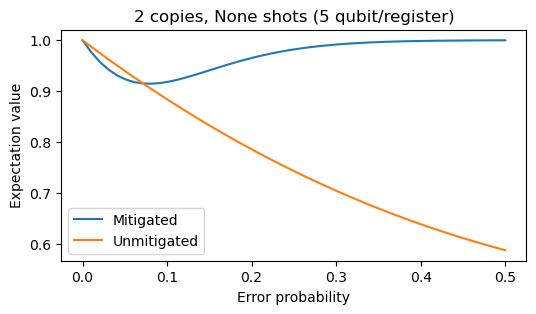

In [52]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots

mit = [] # empty list for mitigated expectation values
unmit = [] # empty list for unmitigated expectation values

for error in tqdm(np.linspace(0,0.5,50)):
    
    err_1q = phase_damping_error(error)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    #noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit.append(mit_exp)
    unmit.append(unmit_exp)

fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(np.linspace(0,0.5,50), mit, label = 'Mitigated')
ax.plot(np.linspace(0,0.5,50), unmit, label = 'Unmitigated')
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='{} copies, {} shots ({} qubit/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value'
)


100%|██████████| 50/50 [01:22<00:00,  1.65s/it]


[Text(0.5, 1.0, '2 copies, None shots (5 qubit/register)'),
 Text(0.5, 0, 'Error probability'),
 Text(0, 0.5, 'Expectation value')]

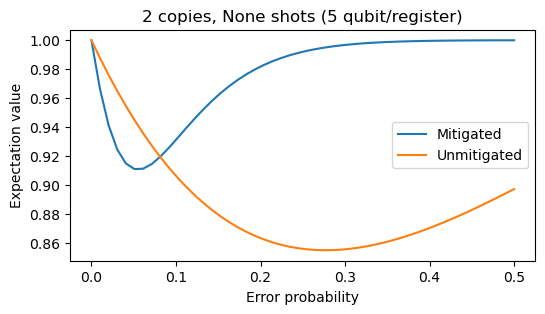

In [56]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = None # we are interested in the exact (algeabraic) expectation value hence no shots

mit = [] # empty list for mitigated expectation values
unmit = [] # empty list for unmitigated expectation values

for error in tqdm(np.linspace(0,0.5,50)):
    
    err_1q = amplitude_damping_error(error)

    noise_m = NoiseModel()
    noise_m.add_all_qubit_quantum_error(err_1q, ['rz', 'id', 'sx', 'x'])
    #noise_m.add_all_qubit_quantum_error(err_2q, ['cx'])

    mit_exp, unmit_exp = circ_tester(numReg = copies, numQ = qubits, numAnc = 1,
                                     sigma = obs, basis_gates = basis_gates,
                                     nb_shots = nb_shots, noise_model = noise_m,
                                     seed = seed, decomp = ['cswap_t', 'h_t'])

    mit.append(mit_exp)
    unmit.append(unmit_exp)

fig, ax = plt.subplots(figsize = (6, 3))
ax.plot(np.linspace(0,0.5,50), mit, label = 'Mitigated')
ax.plot(np.linspace(0,0.5,50), unmit, label = 'Unmitigated')
#ax.hlines(1, 0, 0.5, color = 'mediumaquamarine', label = 'Known expectation value')
ax.legend()
ax.set(
       title ='{} copies, {} shots ({} qubit/register)'.format(copies, nb_shots, qubits),
       xlabel = 'Error probability', 
       ylabel = 'Expectation value'
)